<h1 style="font-family:verdana;"> <center>📚 Pneumonia Detection using VGG16 Transfer Learning📚</center> </h1>
<p><center style="color:#159364; font-family:cursive;">In this notebook, I have evaluated the performance of VGG16 Architecture by fine-tuning it on <code>Chest X-Ray Images(Pneumonia)</code> Dataset.</center></p>
    <center>
<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; In case this notebook is helpful to you in anyway, please do consider leaving feedback. Thanks! :)
</div></center>

***


# 🎯 VGG-16 Model
<div style="text-align:center;">
    <img  src="https://miro.medium.com/v2/resize:fit:850/1*_Lg1i7wv1pLpzp2F4MLrvw.png" />
</div>
VGG-16 is a** Convolutional Neural Network** (CNN) model proposed by Karen Simonyan and Andrew Zisserman of the Visual Geometry Group Lab of Oxford University in 2014. It's considered one of the **best vision model architectures** to date. The model won 1st and 2nd place in the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014.

## 🏗️ Architecture

The architecture of VGG-16 is uniform and consists of 16 convolutional layers. Here's a detailed breakdown:

1. **📥 Input**: The input to the network is an image of dimensions (224, 224, 3).

2. **🔀 Convolutional Layers**: The first two layers have 64 channels of a 3x3 filter size and the same padding. Then, we have two layers of convolution layers of 128 filter size and filter size (3, 3). This is followed by 2 convolution layers of filter size (3, 3) and 256 filters. After that, there are 2 sets of 3 convolution layers. Each has 512 filters of (3, 3) size with the same padding.

3. **🔽 Max-Pooling Layers**: After each set of convolutional layers, there's a max-pooling layer of stride (2, 2).

4. **🔄 Activation Function**: The activation function used in the VGG-16 model is the Rectified Linear Unit (ReLU).

5. **🔗 Fully Connected Layers**: The last three layers of the VGG-16 model are fully connected layers.

6. **📤 Output**: The output of the model is a vector of 1000 values, representing the classification probability for the corresponding class.





# 📚 Import Libraries


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import os

# PyTorch
import torch

# PyTorch - Neural Networks
import torch.nn as nn
from torch import nn

# PyTorch - Gradient Descent Optimizers
from torch import optim

# PyTorch - Others
from torchvision import datasets, transforms, models
import torchvision.transforms as transform
import torchvision.models as models
import torch.nn.functional as F

# Warnings off
import warnings
warnings.filterwarnings("ignore")

# Fix a seed for PyTorch
torch.manual_seed(42);

# 📂 Load Dataset

The dataset respective to already classified category is divided into three sets:
* test set
* train set
* validation set


Found 1349 elements for NORMAL
Found 3893 elements for PNEUMONIA


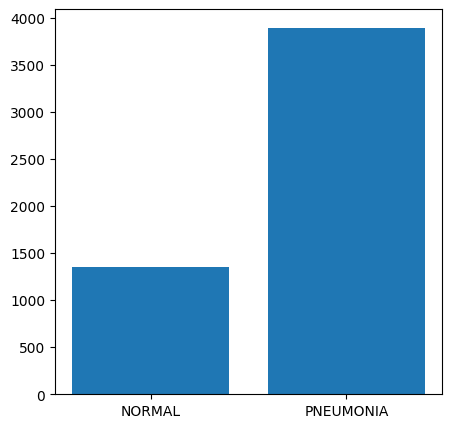

In [ ]:
# Set counters
n_samples_nr_train = len(os.listdir('/content/drive/MyDrive/Complete Version/train_dataset/NORMAL'))
n_samples_pn_train = len(os.listdir('/content/drive/MyDrive/Complete Version/train_dataset/PNEUMONIA'))

# Define two dictionaries
class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}
class_count = {0: n_samples_nr_train, 1: n_samples_pn_train}

# Print results
print(f'Found {class_count[0]} elements for {class_names[0]}')
print(f'Found {class_count[1]} elements for {class_names[1]}')

# Barplot
fig, ax = plt.subplots(figsize=(5,5));
ax.bar([class_names[0], class_names[1]], [class_count[0], class_count[1]]);

In [ ]:
## ===========================
##   WEIGHTING
## ===========================

# Class weights values
samples_0 = class_count[0]
samples_1 = class_count[1]
tot_samples = samples_0 + samples_1

weight_0 = 1 - samples_0/tot_samples
weight_1 = 1 - weight_0  # equivalent to = 1 - samples_1/tot_samples

# Class weights tensor
class_weights = [weight_0, weight_1]
class_weights = torch.FloatTensor(class_weights)
print(class_weights)

tensor([0.7427, 0.2573])


In [ ]:
## ===========================
##   DATA IMPORT
## ===========================

data_transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.CenterCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.RandomGrayscale(),
                    transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
                    transforms.ToTensor()])

# Assosciate the dataset and the transformations with ImageFolder
data = datasets.ImageFolder('/content/drive/MyDrive/Complete Version/train_dataset', transform = data_transform)

In [ ]:
# Split training data in train and validation
train_split, val_split = train_test_split(data, test_size=0.3)

# Print informations
print(f'{len(train_split)} images for training, {len(val_split)} images for validation')

3669 images for training, 1573 images for validation


In [ ]:
# Batch size
batch_size = 64

# Load the datasets with DataLoader
train_loader = torch.utils.data.DataLoader(train_split, batch_size = batch_size, shuffle = True)
val_loader   = torch.utils.data.DataLoader(val_split,   batch_size = batch_size, shuffle = True)

# Class-number association
class_index = {0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cpu


In [ ]:
# Define the test dataset and DataLoader
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(
    root='/content/drive/MyDrive/Complete Version/test_dataset',
    transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # Assuming one image at a time for evaluation
    shuffle=False  # No need to shuffle test data
)

# 🚀 Data Preprocessing and Augmentation

Deep learning models typically require a substantial amount of data for training. Generally, the more data available, the better the model's performance. 📈

**Image Augmentation** 🎨 is a technique used to generate new images for training our deep learning model. These new images are created using the existing training images, eliminating the need for manual collection.

# 🖼️Visualizing the Chest X-rays

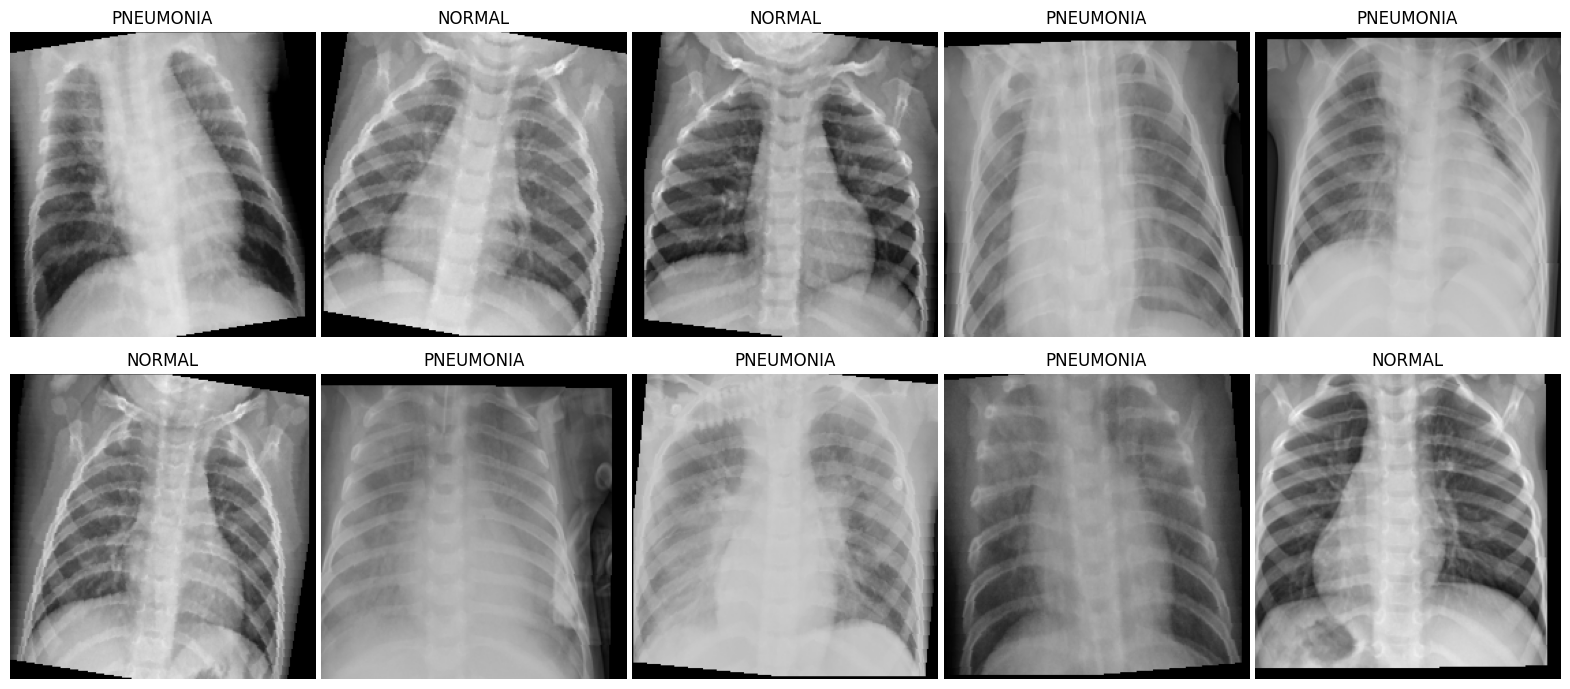

In [ ]:
## Visualize some images

plt.figure(figsize=(20, 10))
n_rows = 2
n_cols = 5

# Extract images from 'train_loader'
images, labels = next(iter(train_loader))

# Display images
for i in range(n_rows*n_cols):
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
  plt.title(class_index[labels.numpy()[i]])
  plt.axis('off')

plt.subplots_adjust(wspace=.02, hspace=-.2)

In [ ]:
inputs, classes = next(iter(train_loader))

# 🚀Define Function for Training


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # Save the initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataset_sizes = {'train': len(train_split), 'val': len(val_split)}  # Adjust to your splits
    dataloaders = {'train': train_loader, 'val': val_loader}  # Map phases to loaders

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs}")
        print("=" * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if we have a new best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best validation Accuracy: {best_acc:.4f}')

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)
    return model


# 🔄Load the Pretrained Model

In [ ]:

# __all__ = [
#     'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
#     'vgg19_bn', 'vgg19',
# ]


# model_urls = {
#     'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
#     'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
#     'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
#     'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
#     'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
#     'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
#     'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
#     'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
# }


# class VGG(nn.Module):

#     def __init__(self, features, num_classes=1000, init_weights=True):
#         super(VGG, self).__init__()
#         self.features = features
#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes),
#         )
#         if init_weights:
#             self._initialize_weights()

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.01)
#                 nn.init.constant_(m.bias, 0)


# def make_layers(cfg, batch_norm=False):
#     layers = []
#     in_channels = 3
#     for v in cfg:
#         if v == 'M':
#             layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#         else:
#             conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
#             if batch_norm:
#                 layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
#             else:
#                 layers += [conv2d, nn.ReLU(inplace=True)]
#             in_channels = v
#     return nn.Sequential(*layers)


# cfgs = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }


# def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
#     if pretrained:
#         kwargs['init_weights'] = False
#     model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls[arch],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#     return model


# def vgg11(pretrained=False, progress=True, **kwargs):
#     r"""VGG 11-layer model (configuration "A") from
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)



# def vgg11_bn(pretrained=False, progress=True, **kwargs):
#     r"""VGG 11-layer model (configuration "A") with batch normalization
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)



# def vgg13(pretrained=False, progress=True, **kwargs):
#     r"""VGG 13-layer model (configuration "B")
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)



# def vgg13_bn(pretrained=False, progress=True, **kwargs):
#     r"""VGG 13-layer model (configuration "B") with batch normalization
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)



# def vgg16(pretrained=False, progress=True, **kwargs):
#     r"""VGG 16-layer model (configuration "D")
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)



# def vgg16_bn(pretrained=False, progress=True, **kwargs):
#     r"""VGG 16-layer model (configuration "D") with batch normalization
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)



# def vgg19(pretrained=False, progress=True, **kwargs):
#     r"""VGG 19-layer model (configuration "E")
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)



# def vgg19_bn(pretrained=False, progress=True, **kwargs):
#     r"""VGG 19-layer model (configuration 'E') with batch normalization
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)


In [ ]:
model_pre = models.vgg16()
state_dict = torch.load('/content/drive/MyDrive/Complete Version/vgg16-397923af.pth')
model_pre.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 🔧Define the Hyperparameters

In [ ]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 🚂Train Phase

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=54)

Epoch: 1/54


In [ ]:
# ======================================
#   SAVE THE MODEL
# ======================================

# Path for saving the best model
path_best_model = '/content/drive/MyDrive/Complete Version/'

# Save the model
torch.save(model_pre.state_dict(), path_best_model + 'best-weighted.pt')
# torch.save(model_pre.state_dict(), path_best_model + 'ehe.pt')

# 📊Evaluate Model Performance


In [ ]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())

            #Store model input images
            input_images.append(inputs)

            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc


# 🧪Testing Phase

In [ ]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

# 📈 Results

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(4):
    for j in range(4):
        # Get the image and labels
        inp = input_images[x].squeeze()

        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()


In [ ]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

In [ ]:
# Build the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ticklables
ticklabels = class_index.values()

# Plot
fig, ax = plt.subplots(figsize=(15,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
import torchvision.models as models
from torchvision import transforms
from PIL import Image

model = '/content/drive/MyDrive/Complete Version/best-model-weighted.pt'


state_dict = torch.load('/content/drive/MyDrive/Complete Version/best-model-weighted.pt' , map_location=torch.device('cpu'))
model = models.vgg16(num_classes=2)
model.load_state_dict(state_dict)


model = model.to(device)
model.eval()


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients and activations
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_module = dict(self.model.named_modules())[self.target_layer]
        target_module.register_forward_hook(forward_hook)
        target_module.register_backward_hook(backward_hook)

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * self.activations, dim=1).squeeze().cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)  # Normalize
        return heatmap

    def visualize(self, image, class_idx, colormap=cv2.COLORMAP_JET):
        self.model.zero_grad()
        output = self.model(image)
        class_score = output[0, class_idx]
        class_score.backward()

        heatmap = self.generate_heatmap(class_idx)
        heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[3]))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)

        image = image.cpu().numpy().squeeze().transpose(1, 2, 0)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        overlay = cv2.addWeighted(np.uint8(255 * image), 0.5, heatmap, 0.5, 0)
        plt.imshow(overlay)
        plt.axis('off')
        plt.show()

# Example Usage:
# Assuming `model` is your VGG-16 model and `test_loader` is your DataLoader for test images.

# Initialize GradCAM
target_layer = 'features.29'  # This is the last conv layer in VGG16
grad_cam = GradCAM(model, target_layer)

# Select an image and its corresponding label
image, label = next(iter(test_loader))
image = image.to(device)  # Move to device
label = label.to(device)  # Move to device

# Run Grad-CAM and visualize
class_idx = label.item()  # Assume single batch
# Check the shape of the image tensor before passing it
print(image.shape)  # Ensure it's [batch_size, channels, height, width]

# If the shape is incorrect (e.g., [1, 1, 3, 224, 224]), fix it
if len(image.shape) == 5:
    image = image.squeeze(1)  # Remove the extra dimension

# Call Grad-CAM visualize
grad_cam.visualize(image, class_idx)

